In [1]:
import random
import warnings
warnings.filterwarnings('ignore')

import requests
import torch
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn.functional import linear
from torch.nn.functional import softmax,relu

from models.backbone import Backbone, Joiner
from models.detr import DETR
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from powerline_utils import transform, rescale_bboxes, plot_results, CLASSES
from util.misc import (NestedTensor, nested_tensor_from_tensor_list)

torch.set_grad_enabled(False)
%matplotlib inline

In [2]:
hidden_dim = 256
dropout = 0.1
nheads = 8
dim_feedforward = 2048
enc_layers = 6
dec_layers = 6
pre_norm = False
num_classes = 3
num_queries = 10
aux_loss = False

In [3]:
backbone = Backbone('resnet50', True, False, False)

In [4]:
N_steps = hidden_dim // 2
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
model = Joiner(backbone, position_embedding)
model.num_channels = backbone.num_channels
backbone = model

In [5]:
transformer = Transformer(
    d_model=hidden_dim,
    dropout=dropout,
    nhead=nheads,
    dim_feedforward=dim_feedforward,
    num_encoder_layers=enc_layers,
    num_decoder_layers=dec_layers,
    normalize_before=pre_norm,
    return_intermediate_dec=True,
)

In [6]:
model = DETR(
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=num_queries,
    aux_loss=aux_loss,
)

In [7]:
model.load_state_dict(torch.load(r'C:\Users\55378\Desktop\detrs\detr\output\checkpoint.pth')['model'])
model.eval();

In [8]:
im = Image.open("D:/dataset/coco_powerline_1/train/26_00211.jpg")
img = transform(im).unsqueeze(0)

In [9]:
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.91
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

In [15]:
outputs['pred_boxes']

tensor([[[0.6190, 0.4875, 0.6171, 0.9513],
         [0.8681, 0.5899, 0.2597, 0.5357],
         [0.8257, 0.2568, 0.3410, 0.4840],
         [0.8059, 0.6553, 0.3954, 0.6777],
         [0.7484, 0.4999, 0.5208, 0.9546],
         [0.6676, 0.5052, 0.5483, 0.9970],
         [0.7326, 0.5397, 0.5492, 0.9216],
         [0.5396, 0.3047, 0.5002, 0.5693],
         [0.7519, 0.4011, 0.4948, 0.7630],
         [0.8814, 0.7829, 0.2413, 0.4620]]])

In [22]:
for p in probas[keep]:
    print(p.argmax())

tensor(0)
tensor(0)


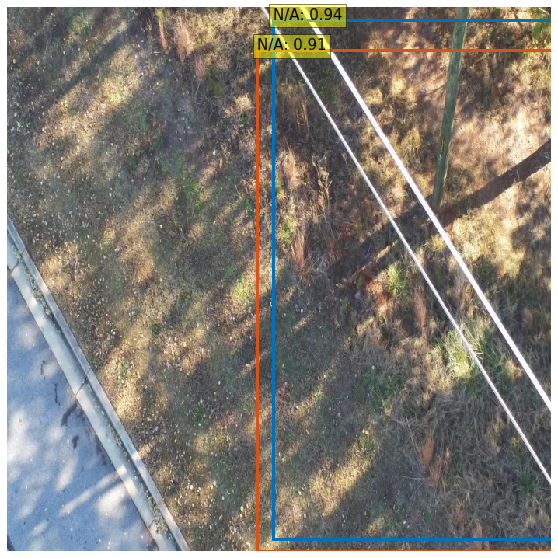

In [10]:
plot_results(im, probas[keep], bboxes_scaled)